# Предсказать форму облаков

## Подключение библиотек

In [19]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import requests

from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from PIL import Image
from io import BytesIO

## Загрузка данных

In [2]:
train = pd.read_csv("../data/clouds/train.csv.gz")
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    22184 non-null  object
 1   EncodedPixels  11836 non-null  object
dtypes: object(2)
memory usage: 346.8+ KB
None


In [3]:
print(train.head())

          Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...


## Очистка данных

In [4]:
train["Image"] = train["Image_Label"].str.split("_").str[0]
train["Label"] = train["Image_Label"].str.split("_").str[1]
train.drop(labels=["Image_Label"], axis=1, inplace=True)
print(train.head())

                                       EncodedPixels        Image   Label
0  264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg    Fish
1  1355565 1002 1356965 1002 1358365 1002 1359765...  0011165.jpg  Flower
2                                                NaN  0011165.jpg  Gravel
3                                                NaN  0011165.jpg   Sugar
4  233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg    Fish


## Размеченные данные

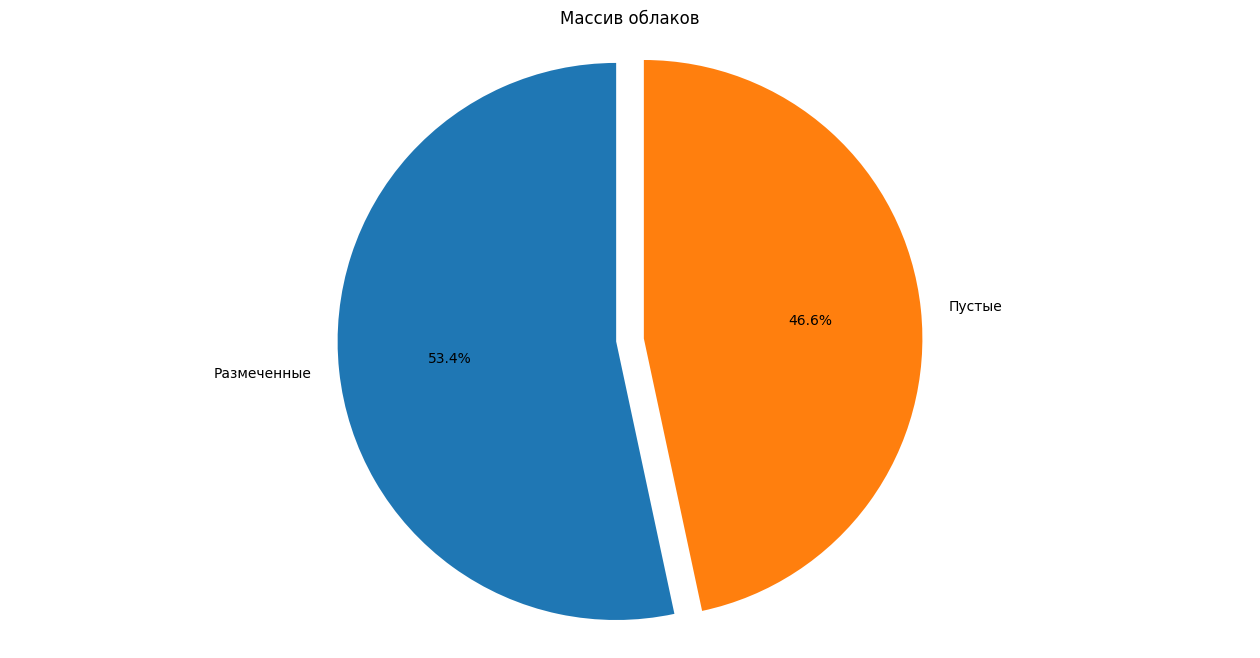

In [5]:
sizes = [train.EncodedPixels.count(), len(train) - train.EncodedPixels.count()]
explode = (0, 0.1)
fig, ax = plt.subplots(figsize=(16, 8))
ax.pie(
    sizes,
    explode=explode,
    labels=["Размеченные", "Пустые"],
    autopct="%1.1f%%",
    startangle=90,
)
ax.axis("equal")
ax.set_title("Массив облаков")
plt.show()

## Формы облаков

In [6]:
fish = train[train["Label"] == "Fish"].EncodedPixels.count()
flower = train[train["Label"] == "Flower"].EncodedPixels.count()
gravel = train[train["Label"] == "Gravel"].EncodedPixels.count()
sugar = train[train["Label"] == "Sugar"].EncodedPixels.count()
sizes = [fish, flower, gravel, sugar]

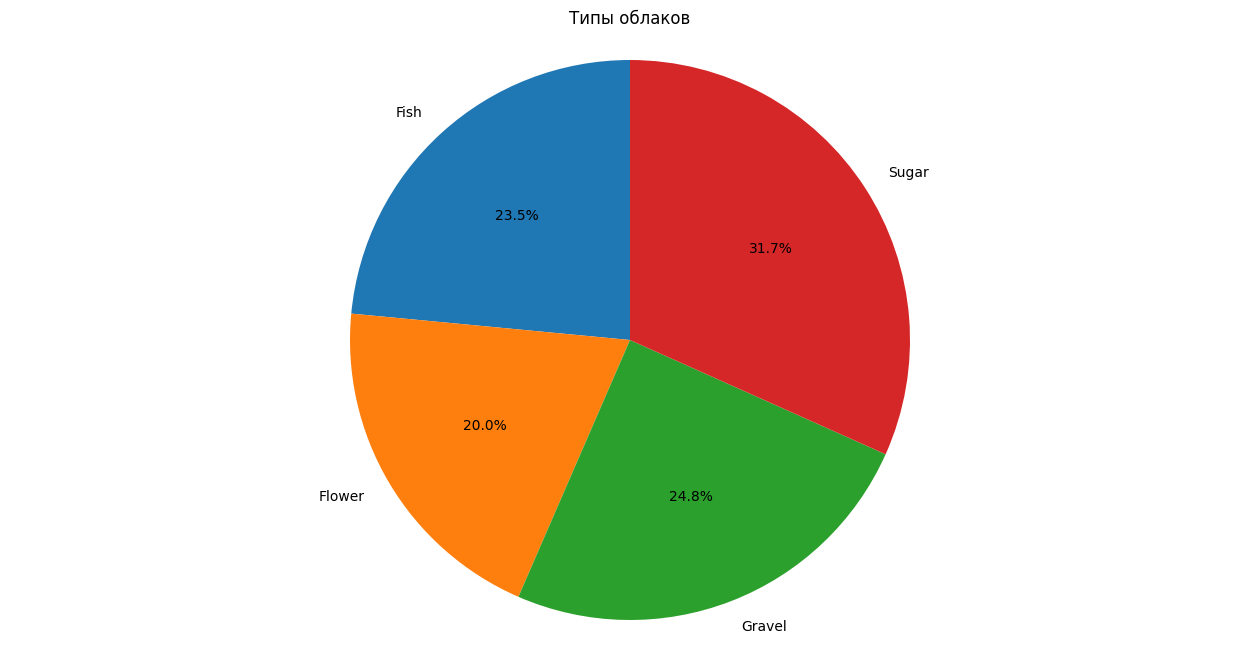

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.pie(
    sizes,
    labels=[
        "Fish",
        "Flower",
        "Gravel",
        "Sugar",
    ],
    autopct="%1.1f%%",
    startangle=90,
)
ax.axis("equal")
ax.set_title("Типы облаков")
plt.show()

## Количество разных облаков на изображениях

In [ ]:
_, area = plt.subplots(figsize=(6, 6))
train.groupby("Image")['EncodedPixels'].count().hist(ax=area)
ax.set_title("Число разных облаков")
plt.show()

## Корреляция между формами облаков

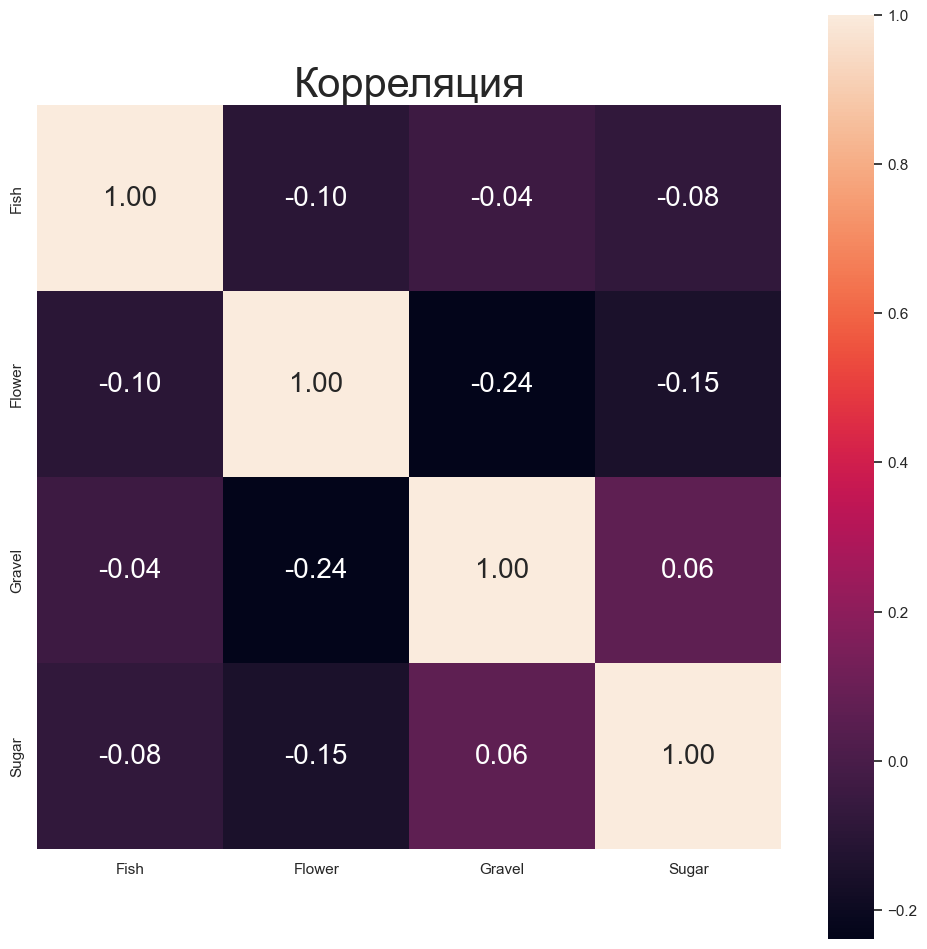

In [9]:
labels = train["Label"].unique()
for label in labels:
    train["Label_" + label] = ((train["EncodedPixels"].notnull())
                              & (train["Label"] == label)).astype("int8")
train_corr = train.groupby("Image")[["Label_Fish", "Label_Flower", "Label_Gravel", "Label_Sugar"]].sum()
corrs = np.corrcoef(train_corr.values.T)
sns.set(rc={"font.size":20, "figure.figsize":(12, 12)})
sns.heatmap(
    corrs,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    yticklabels=labels,
    xticklabels=labels,
).set_title("Корреляция", fontsize=30)
plt.show()

## Области облаков на изображении

In [10]:
def mask_rate(a, x, y):
    b = a // 1400
    return np.round(x*(b*x//2100) + y*(a % 1400)//1400).astype("uint32")

In [11]:
def calc_mask(px, x=2100, y=1400):
    p = np.array([int(n) for n in px.split(" ")]).reshape(-1, 2)
    mask = np.zeros(x*y, dtype="uint8")
    for i, m in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(m + i, x, y)] = 1
    return mask.reshape(y, x).transpose()

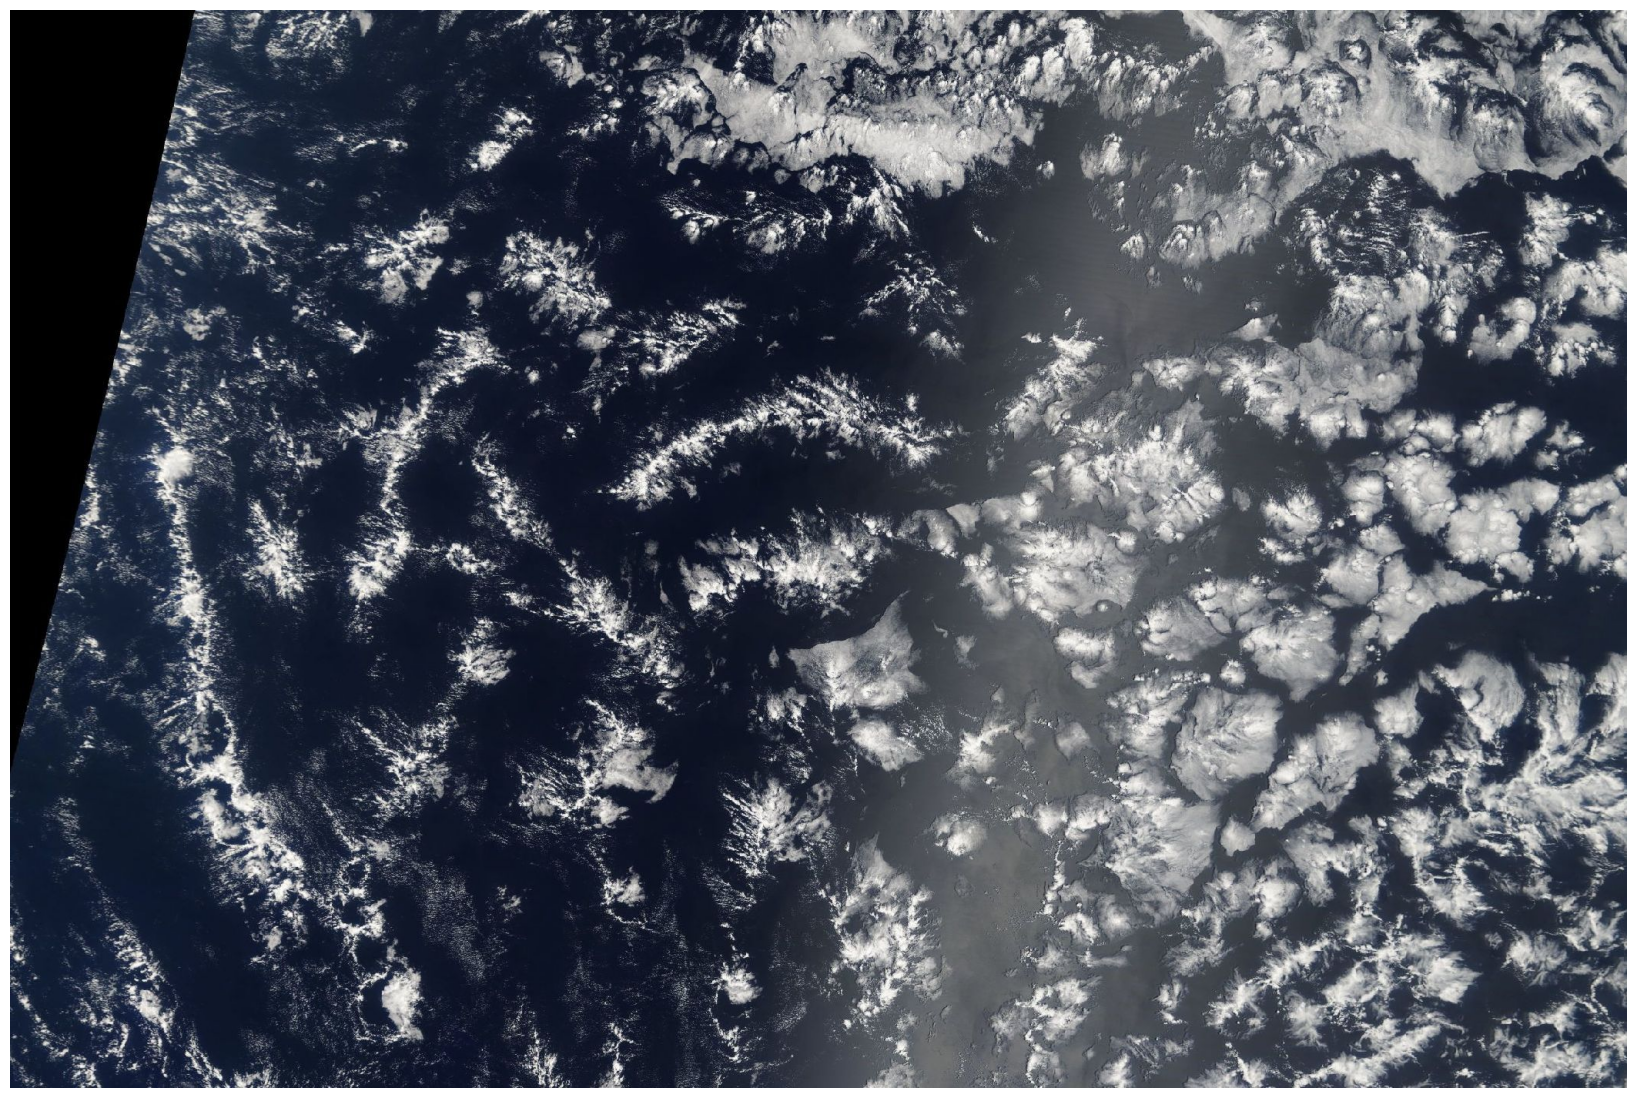

In [15]:
plt.figure(figsize=(21, 14))
plt.axis("off")
plt.imshow(mpimg.imread("../data/clouds/0011165.jpg"))

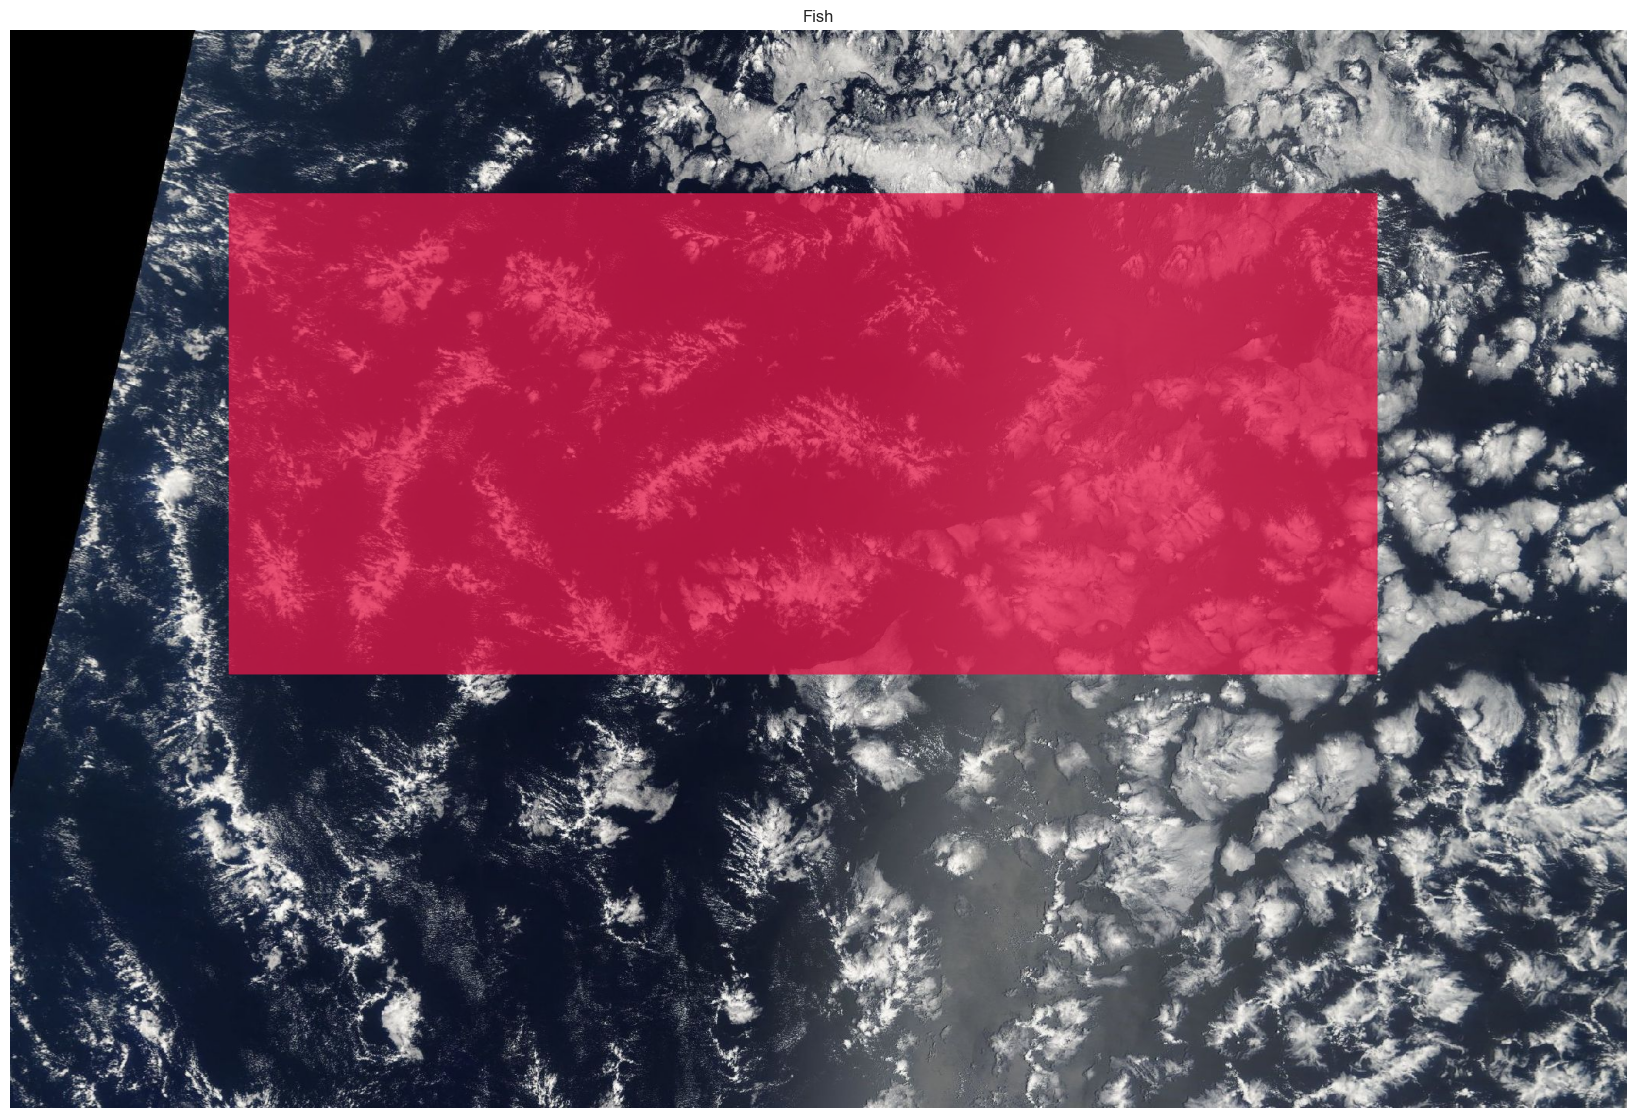

In [20]:
img = np.array(Image.open("../data/clouds/0011165.jpg"))
mask = calc_mask(train["EncodedPixels"].values[0])
segmap = SegmentationMapsOnImage(mask, mask.shape)
fig, area = plt.subplots(figsize=(21, 14))
area.axis("off")
plt.title("Fish")
area.imshow(np.array(segmap.draw_on_image(img)).reshape(img.shape))